# Business Case- Predict the practice of minimising disease in crops to increase quantity or quality of harvest yield.the system supports farmers in making informed decisions, ultimately leading to enhanced productivity, reduced environmental impact, and improved livelihoods in rice-growing regions worldwide.


Task 1:-To prepare a complete data analysis report on the given data.

Task 2:-To create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

Task3:- Analyze various techniques like Data Augmentation, etc and create a
report on that.



# Importing the libraries


In [ ]:
#import all required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\ANKIT\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setting the constants


In [4]:
IMAGE_SIZE=256
BATCH_SIZE=10
channels=3
epochs = 100

# Importing data into tensorflow dataset object


In [5]:
#loading and preprocessing images.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'Data',                                                       
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.


# Domain analysis and Data Information


Rice is one of the most important staple crops worldwide, providing sustenance to over half of the world's population. However, rice plants are vulnerable to several diseases that can severely impact the yield and quality of rice production. Some of the major rice diseases that affect rice plants include bacterial leaf blight, brown spot, and leaf smut.
This dataset contains 120 jpg images of disease-infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.

Classes :

● Leaf smut ● Brown spot ● Bacterial leaf blight

Leaf smut caused by the fungus Entyloma oryzae, is a relatively less common rice disease. The symptoms of leaf smut include the formation of small, round, and reddish-brown spots on the leaves. These spots later turn black and produce powdery spores. Although leaf smut does not usually cause significant yield losses, it can affect the quality of rice grains by reducing their weight and size .

Brown spot, caused by the fungus Cochliobolus miyabeanus, is another major rice disease that can cause significant yield losses. The disease is characterized by small, oval to elliptical spots on the leaves, which turn brown with a yellow halo. In severe cases, the spots can coalesce and cause the leaves to wither and die. Brown spot can also affect the panicles, leading to a reduction in grain quality and yield .

Bacterial leaf blight, caused by the bacterium Xanthomonas oryzae pv. oryzae, is a serious disease that can cause extensive damage to rice plants. The symptoms of bacterial leaf blight include water-soaked lesions on the leaves, which later turn brown and dry up. In severe cases, the disease can cause wilting and death of the plant, leading to a significant reduction in crop yield .

In [6]:
#class names
class_names = dataset.class_names
class_names

['Bacterial leaf blight-20200814T055237Z-001', 'Brown spot', 'Leaf smut']

In [7]:
#total batches
len(dataset)


12

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(10, 256, 256, 3)
[1 0 2 1 0 0 2 1 2 1]


# Observations
Each element in the dataset is a tuple. First element is a batch of 10 elements of images. Second element is a batch of 10 elements of class labels


# Data visualization


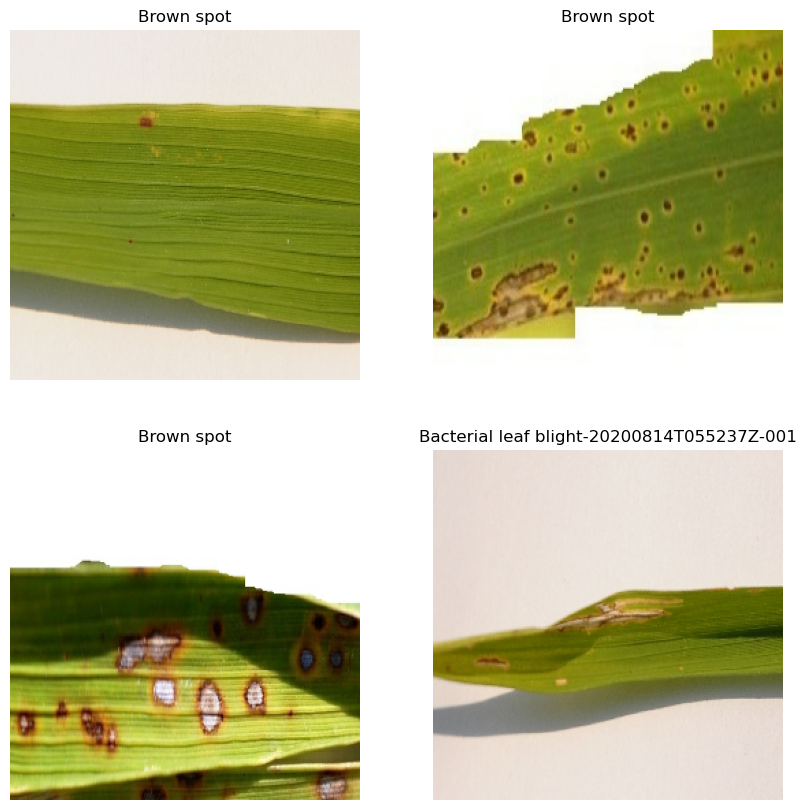

In [9]:
#create a new figure with height and width a square figure with both dimensions equal to 10 inches.
plt.figure(figsize=(10,10))                
for image_batch,label_batch in dataset.take(1):#contains a batch of images, and label_batch contains corresponding labels extract one batch from one dataset.
    for i in range(4): #first 4 images
        ax = plt.subplot(2,2,i+1)# creates a subpolt in number form.
        plt.imshow(image_batch[i].numpy().astype('uint8'))#converts it to an unsigned 8-bit integer format, which is suitable for displaying images.
        plt.title(class_names[label_batch[i]])# gives the class names of the image.
        plt.axis('off')


# Creating function to split the data for training, testing and validation.
Dividing dataset into 3 parts. Namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model



In [10]:
#TensorFlow dataset specifying the proportion of data to allocate to training, validation, and test sets, respectively and shuffle the dataset in buffer size.
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)#total number of elements in the dataset
    
    if shuffle:#Shuffling helps in randomizing the order of elements in the dataset
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = 8 # size of the training set based on the train_split ratio.
    val_size = 2 #size of the validation set based on the val_split ratio.
    
    train_ds = ds.take(train_size)  #elements from the shuffled (or original) dataset ds to create the dataset
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [12]:
train_ds,val_ds,test_ds = get_partition_tf(dataset)

In [13]:
len(test_ds)

2

# Chache, shuffle and prefetch the dataset

Catche -

Instead of recomputing these values for each training iteration, the CNN can access and reuse them, which significantly speeds up training. This is especially helpful in CNNs where data augmentation or complex preprocessing is involved.

Prefetch -

During CNN training, there are often periods where the model is computing gradients while waiting for the next batch of data to load. Prefetching allows us to start loading the next batch in the background while the model is training on the current batch. This overlapping of operations helps keep the GPU or CPU busy and can lead to faster training times.

Shuffle -

If we feed the CNN consecutive batches of data that are highly correlated (e.g., all images of one class followed by another), the model may learn patterns based on this order, which can lead to poor generalization. Shuffling ensures that each batch contains a random mix of samples from different classes, making the training process more robust.



In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [16]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2.18.0-dev20240625
3.4.1.dev2024070203


In [19]:
#preprocessing
import tensorflow as tf
from tensorflow.keras import layers

# Define the preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])



# Data Augmentation

Data augmentation is a technique used to increase the size and diversity of a dataset by applying various transformations to the existing data. This technique has become an essential tool in computer vision and image processing tasks, such as object recognition and classification, due to its ability to enhance the generalization ability of machine learning models and prevent overfitting.

In the context of our rice leaf disease image classification project, data augmentation can play a crucial role in improving the performance and robustness of our model. By generating new images with different variations such as rotations, flips, zooms, and other transformations, we can increase the diversity of our dataset and provide our model with more examples to learn from, which can lead to better classification accuracy and robustness to variations in the real-world data.



In [21]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the data augmentation pipeline
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])


In [22]:
# Applying Data Augmentation on train dataset

train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


# Model Architecture

Here use a CNN coupled with a Softmax Activation in the output layerand also add the initial layers for Resizing, Normalization and Data Augmentation.


In [23]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,channels)#Specifies the shape of the input data 
n_classes = 3 #the number of classes in the classification

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),#convolutional layer with 32 filters of size with ReLU activation function.
    layers.MaxPool2D((2,2)),   #Max pooling helps in reducing the spatial dimensions of the representation of no.fo parameters.
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),# flatten is input tensor in to  1D array and it is necessary for conectionfor layers before feeding.
    layers.Dense(64,activation='relu'),#fully connected layer with 64 neurons and ReLU activation function.
    layers.Dense(n_classes, activation='softmax')#n_classes(no.of classes) ,Softmax is multi-class classification to output probabilities for each class.
])

model.build(input_shape=input_shape)


In [24]:
#architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (10, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (10, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (10, 12, 12, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (10, 6, 6, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (10, 1152)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10, 64)                    │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,699 (725.39 KB)

 Trainable params: 185,699 (725.39 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric.



In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(train_ds,epochs=epochs,batch_size=BATCH_SIZE,verbose=1,
         validation_data=val_ds)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.2380 - loss: 1.1135 - val_accuracy: 0.2500 - val_loss: 1.1007
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 650ms/step - accuracy: 0.4156 - loss: 1.0971 - val_accuracy: 0.3000 - val_loss: 1.1040
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step - accuracy: 0.4076 - loss: 1.0909 - val_accuracy: 0.3500 - val_loss: 1.0950
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step - accuracy: 0.4479 - loss: 1.0869 - val_accuracy: 0.3500 - val_loss: 1.0980
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.4747 - loss: 1.0789 - val_accuracy: 0.3000 - val_loss: 1.1034
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - accuracy: 0.3806 - loss: 1.0933 - val_accuracy: 0.3500 - val_loss: 1.0837
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 728ms/step - accuracy: 0.5111 - loss: 1.0561 - val_accuracy: 0.4500 - val_loss: 1.0826
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 650ms/step - accuracy: 0.4329 - loss: 1.0148 - val_accuracy: 0.4000 - val

In [27]:
score = model.evaluate(test_ds)#the performance of a trained TensorFlow/Keras model on a test dataset.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8333 - loss: 0.5211


In [28]:
score

[0.5065780282020569, 0.800000011920929]

# Plotting the Accuracy and Loss Curves


In [29]:
history

In [30]:
history.params


{'verbose': 1, 'epochs': 100, 'steps': 8}

In [31]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

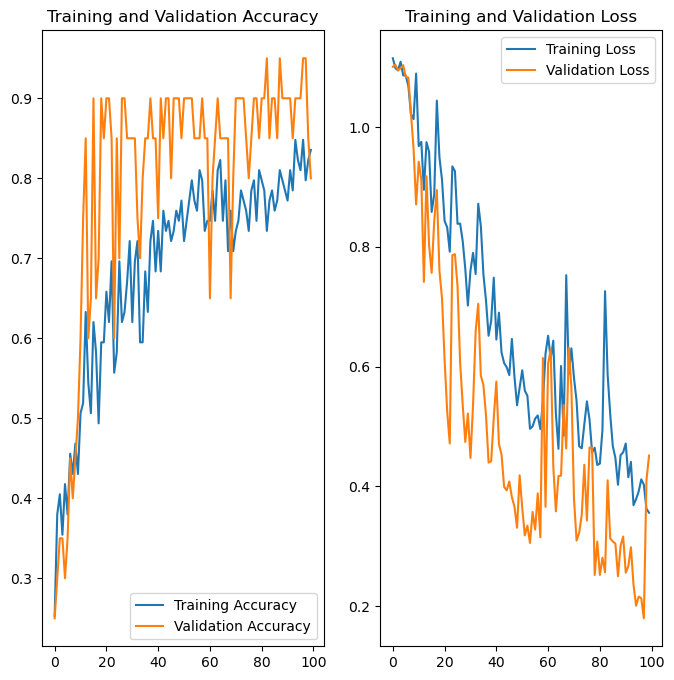

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image


first image to predict
actual label: Leaf smut
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
predicted label: Leaf smut


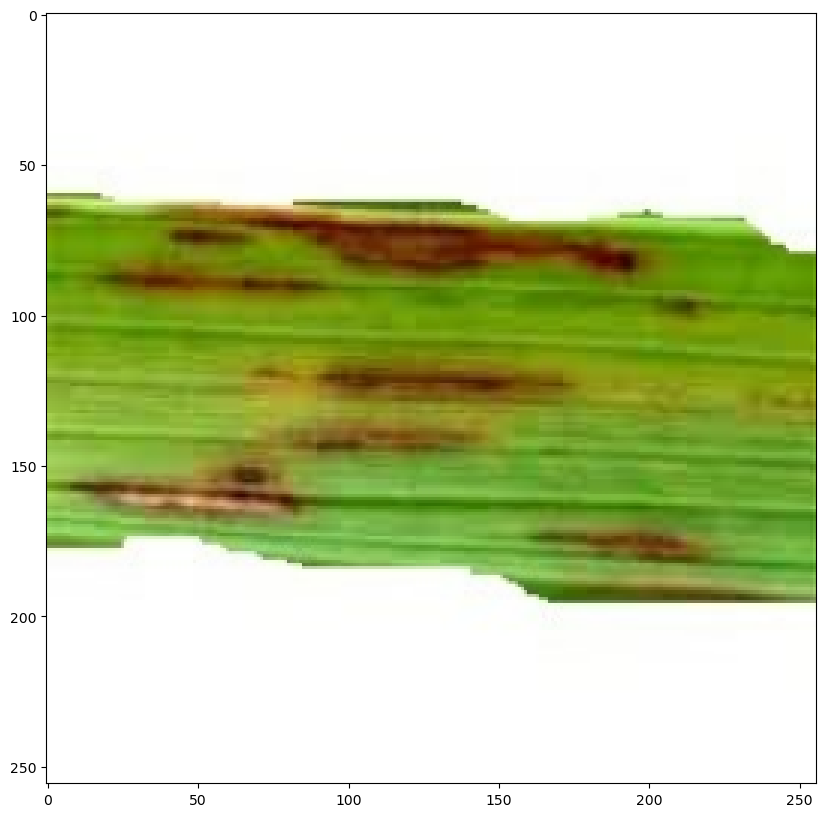

In [33]:
#prediction on sample
plt.figure(figsize=(10,10))
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


# Creating a function for inference


In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Prediction on few Sample Images


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


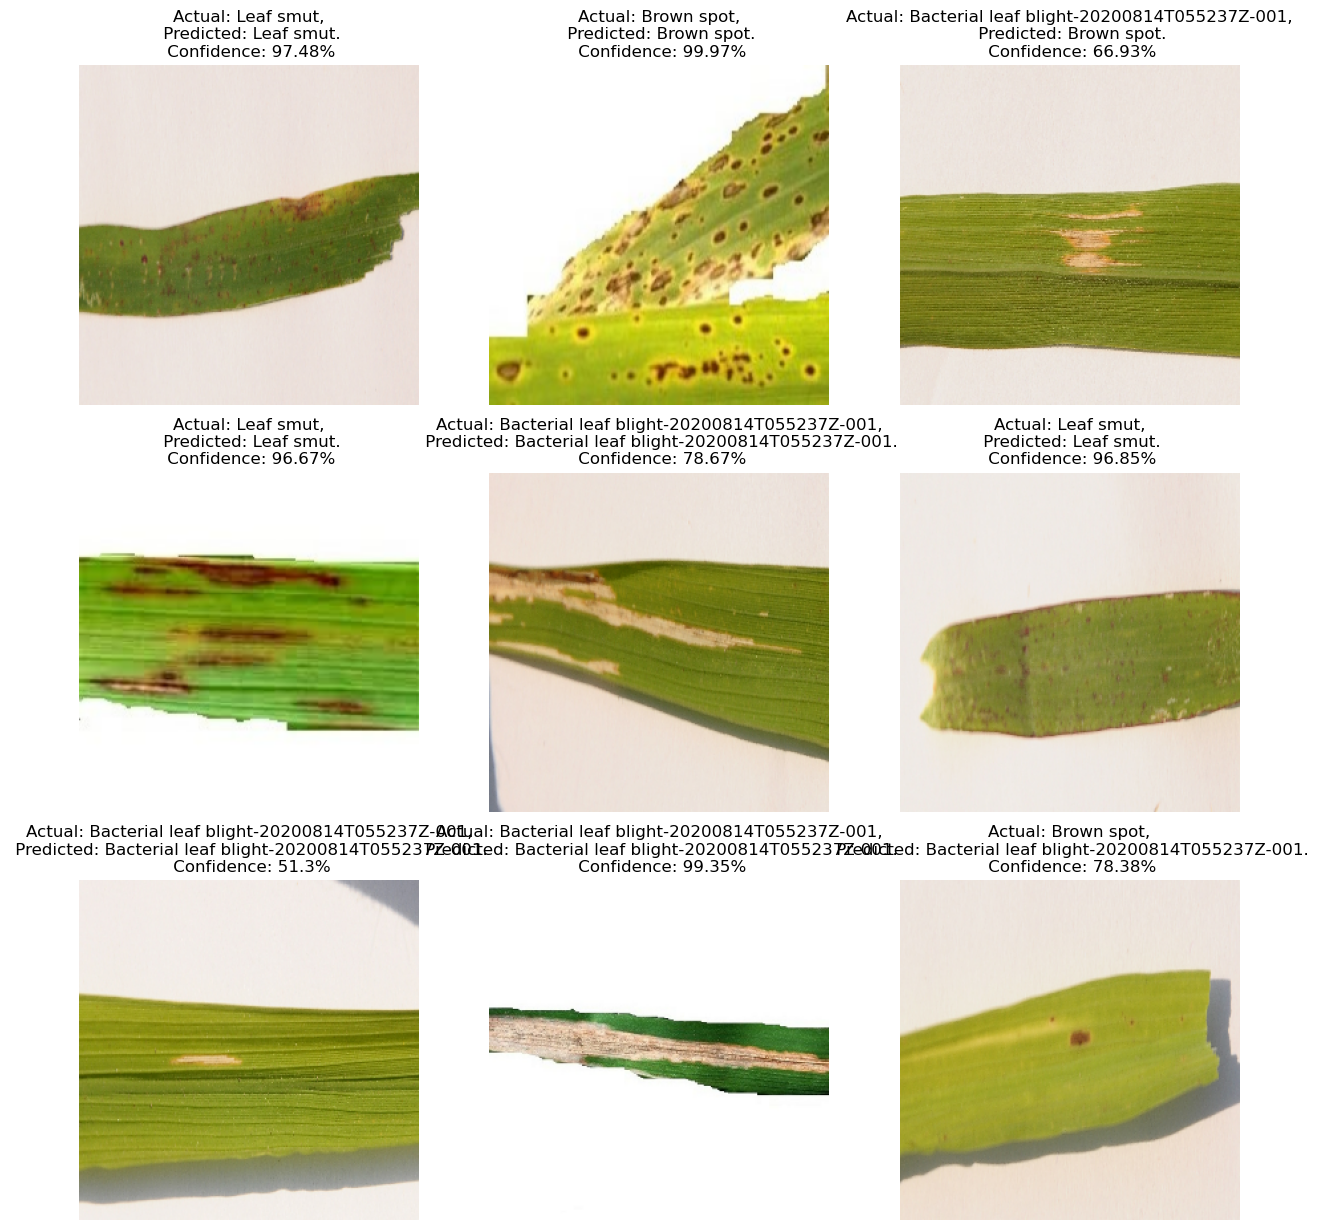

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")